This project takes retail sales timeseries data, trains and tests the dataset and then builds a model to predict the monthly retail sales. 

In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.stattools import adfuller

C:\Users\mksis\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Load the dataset
df = pd.read_csv('/Users/mksis/Documents/Data Science/DS630 Predictive Analytics/Data Sets/us_retail_sales.csv')
df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1992,146925,147223,146805,148032,149010,149800,150761.0,151067.0,152588.0,153521.0,153583.0,155614.0
1,1993,157555,156266,154752,158979,160605,160127,162816.0,162506.0,163258.0,164685.0,166594.0,168161.0
2,1994,167518,169649,172766,173106,172329,174241,174781.0,177295.0,178787.0,180561.0,180703.0,181524.0
3,1995,182413,179488,181013,181686,183536,186081,185431.0,186806.0,187366.0,186565.0,189055.0,190774.0
4,1996,189135,192266,194029,194744,196205,196136,196187.0,196218.0,198859.0,200509.0,200174.0,201284.0


In [3]:
df = df.melt(id_vars = 'YEAR')
df.head()

,YEAR,variable,value
0,1992,JAN,146925.0
1,1993,JAN,157555.0
2,1994,JAN,167518.0
3,1995,JAN,182413.0
4,1996,JAN,189135.0


In [4]:
#Renaming Columns
df.columns = ['YEAR', 'MONTH', 'SALES']


#Concatenating Month and Year
df['DATE'] = df['MONTH'] +'-'+ df['YEAR'].astype(str)

#Converting DATE to a date
df['DATE'] = pd.to_datetime(df['DATE'])
#df.head()

#Adding Column for Order of Month
df['NUM'] = df['DATE'].dt.month
#df

#Concatenating NUM_MONTH and MONTH
df['NUM_MONTH'] = df['NUM'].astype(str) + '-' + df['MONTH']
df

,YEAR,MONTH,SALES,DATE,NUM,NUM_MONTH
0,1992,JAN,146925.0,1992-01-01,1,1-JAN
1,1993,JAN,157555.0,1993-01-01,1,1-JAN
2,1994,JAN,167518.0,1994-01-01,1,1-JAN
3,1995,JAN,182413.0,1995-01-01,1,1-JAN
4,1996,JAN,189135.0,1996-01-01,1,1-JAN
...,...,...,...,...,...,...
355,2017,DEC,433282.0,2017-12-01,12,12-DEC
356,2018,DEC,434803.0,2018-12-01,12,12-DEC
357,2019,DEC,458055.0,2019-12-01,12,12-DEC
358,2020,DEC,484782.0,2020-12-01,12,12-DEC


In [5]:
#Removing NANs
df_null = pd.isnull(df['SALES'])
#df_null

df = df.dropna(subset = ['SALES'])
df.shape

(354, 6)

In [6]:
df.describe()

,YEAR,SALES,NUM
count,354.000000,354.000000,354.000000
mean,2006.254237,307006.573446,6.449153
std,8.530419,94335.828235,3.456564
min,1992.000000,146805.000000,1.000000
25%,1999.000000,231402.000000,3.000000
50%,2006.000000,309534.500000,6.000000
75%,2014.000000,378193.750000,9.000000
max,2021.000000,562269.000000,12.000000


### 1. Plot the data with proper labeling and make some observations on the graph.


In [7]:
gb_month = df.groupby(['MONTH'])['SALES'].sum()
gb_month

MONTH
APR    9201588.0
AUG    8858107.0
DEC    8934889.0
FEB    9156027.0
JAN    9144115.0
JUL    8826888.0
JUN    9342209.0
MAR    9226007.0
MAY    9276169.0
NOV    8926052.0
OCT    8912008.0
SEP    8876268.0
Name: SALES, dtype: float64

[]

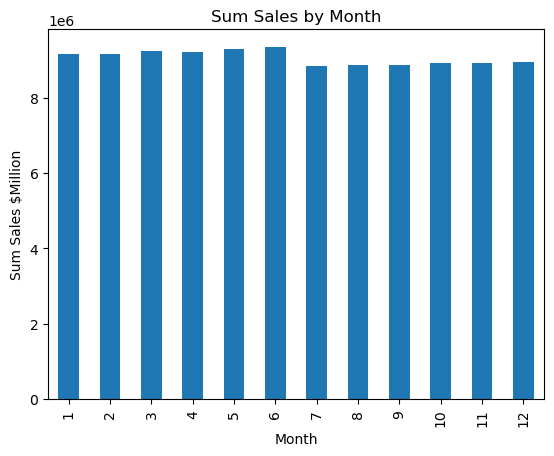

In [8]:
gb_month = df.groupby(['NUM'])['SALES'].sum().plot(kind = 'bar', title = 'Sum Sales by Month', xlabel = 'Month', ylabel = 'Sum Sales $Million')
gb_month.plot()

[]

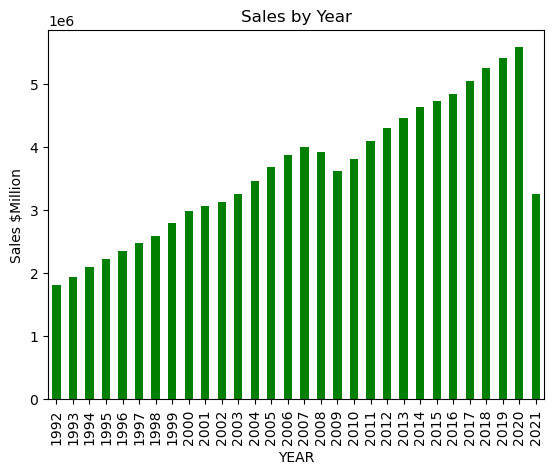

In [9]:
gb_year = df.groupby(['YEAR'])['SALES'].sum().plot(kind = 'bar', title = 'Sales by Year', ylabel = 'Sales $Million', color = 'Green')
gb_year.plot()

#Note: Year 2021 only has sales through June

<AxesSubplot:title={'center':'Stacked Yearly Sales'}, xlabel='Month', ylabel='Sales $Million'>

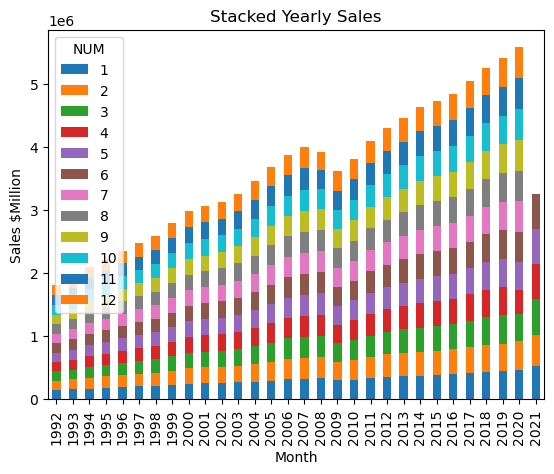

In [10]:
gb_year_month = df.groupby(['YEAR', 'NUM'])['SALES'].sum().unstack()
gb_year_month.plot(kind = 'bar', stacked = True, title = 'Stacked Yearly Sales',xlabel = 'Month', ylabel = 'Sales $Million')
#Note: Year 2021 only has sales through June



<AxesSubplot:title={'center':'Sales Timeline'}, xlabel='DATE', ylabel='Sales $Million'>

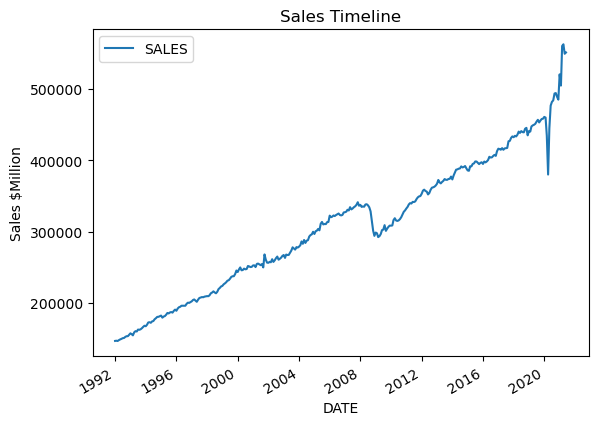

In [11]:
df.plot(x = 'DATE', y = 'SALES', kind = 'line', title = 'Sales Timeline', ylabel = 'Sales $Million')

#### Observations on the graphs
By looking at the sum of sales by Month - there does not seem to be a significant variance of sales depending on the months. Meaning, there is not a significant difference between the sales of January compared to December, or any other month.

By viewing the sum of sales by Year, you can see there is a consistant increase of sales by each year. Sales from 1992 nearly double by 2020.



### 2. Split this data into a training and test set. Use the last year of data (July 2020 – June 2021) of data as your test set and the rest as your training set.

In [12]:
#Order the data frame by DATE
df = df.sort_values(by = ['DATE'])
df

,YEAR,MONTH,SALES,DATE,NUM,NUM_MONTH
0,1992,JAN,146925.0,1992-01-01,1,1-JAN
30,1992,FEB,147223.0,1992-02-01,2,2-FEB
60,1992,MAR,146805.0,1992-03-01,3,3-MAR
90,1992,APR,148032.0,1992-04-01,4,4-APR
120,1992,MAY,149010.0,1992-05-01,5,5-MAY
...,...,...,...,...,...,...
59,2021,FEB,504458.0,2021-02-01,2,2-FEB
89,2021,MAR,559871.0,2021-03-01,3,3-MAR
119,2021,APR,562269.0,2021-04-01,4,4-APR
149,2021,MAY,548987.0,2021-05-01,5,5-MAY


In [13]:
#Set Index
df_set = df.set_index('DATE', inplace = True)


#Deleting unnecessary columns from dataset (YEAR, MONTH, NUM, NUM_MONTH)
df_set = df.drop(columns = ['YEAR', 'MONTH', 'NUM', 'NUM_MONTH'])

#Setting Frequency
#df_set = df_set.asfreq('m')

df_set.tail()

,SALES
DATE,
2021-02-01,504458.0
2021-03-01,559871.0
2021-04-01,562269.0
2021-05-01,548987.0
2021-06-01,550782.0


In [14]:
#splitting dataset into training and testing
size = int(len(df_set)-12) #size of training set will be entire dataframe minus 12 months

#training df should be from beginning of dataframe to June 2020
df_train = df_set.iloc[:size]

#testing df should be July 2020-June 2021
df_test = df_set.iloc[size:]
df_test

,SALES
DATE,
2020-07-01,481627.0
2020-08-01,483716.0
2020-09-01,493327.0
2020-10-01,493991.0
2020-11-01,488652.0
2020-12-01,484782.0
2021-01-01,520162.0
2021-02-01,504458.0
2021-03-01,559871.0


### 3. Use the training set to build a predictive model for the monthly retail sales.

In [15]:
#Checing for stationality
stationary_result = df_set.values
adfuller(stationary_result)

#p-value = .99; (p-value > .05); meaning data is non-stationary
#d will be 0 because dataset is stationary

(1.4490526692726289,
 0.9973259755033455,
 12,
 341,
 {'1%': -3.449673193310592,
  '5%': -2.8700533746644323,
  '10%': -2.5713055939491403},
 6846.754053139283)

In [16]:
#Import library to plot stationality
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error


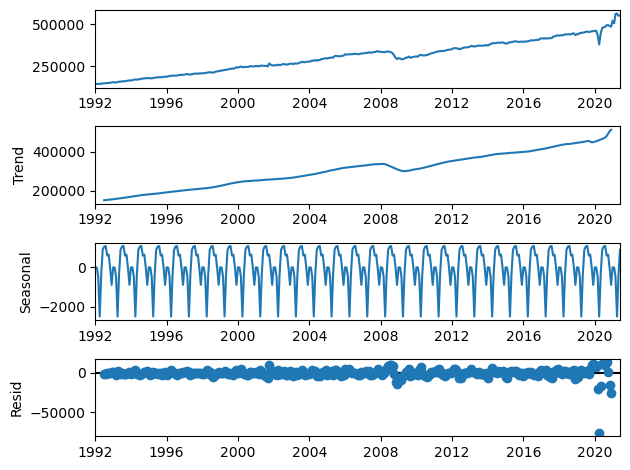

In [17]:
decomposition = sm.tsa.seasonal_decompose(df_set, model = 'additive')
fig = decomposition.plot()
plt.show()

C:\Users\mksis\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


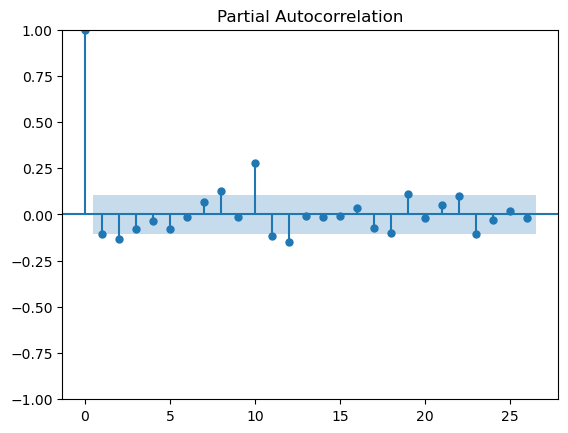

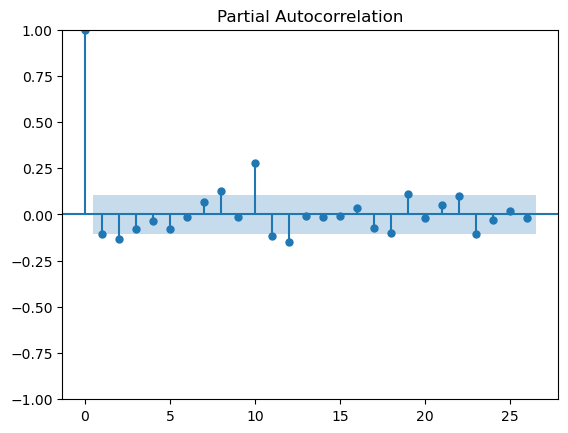

In [18]:
#Finding p
plot_pacf(df_set.SALES.diff().dropna())
#n-1; p is 1

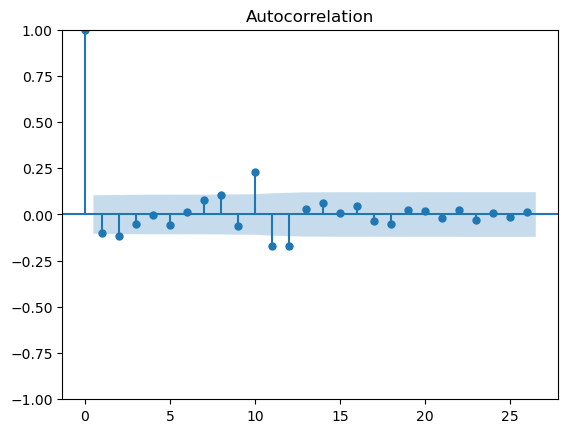

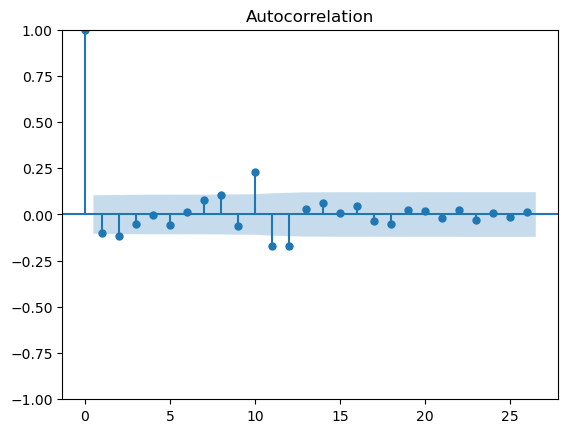

In [19]:
#Finding q
plot_acf(df_set.SALES.diff().dropna())
#n-1
#1-1 = 0; q will be 0

In [20]:
#ARIMA
p = 6
d = 3 # because stationary
q = 5

In [21]:
#building model on the training dataset
model = ARIMA(df_train, order = (p, d, q)).fit()
model

C:\Users\mksis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mksis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mksis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mksis\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\mksis\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Ch

### 4. Use the model to predict the monthly retail sales on the last year of data.

In [22]:
pred = model.predict(start = len(df_train), end = (len(df_set)-1))
pred

2020-07-01    493972.779869
2020-08-01    496653.248555
2020-09-01    497477.104249
2020-10-01    497854.428547
2020-11-01    499404.914397
2020-12-01    501559.641580
2021-01-01    503170.551894
2021-02-01    506057.473124
2021-03-01    507341.526986
2021-04-01    510212.862302
2021-05-01    511833.520086
2021-06-01    514226.620596
Freq: MS, Name: predicted_mean, dtype: float64

### 5. Report the RMSE of the model predictions on the test set.

In [23]:
rmse = np.sqrt(mean_squared_error(df_test,pred))
print('RMSE: ', rmse)

#Larger the RMSE, the larger the difference

RMSE:  27728.12353081217


<AxesSubplot:xlabel='DATE'>

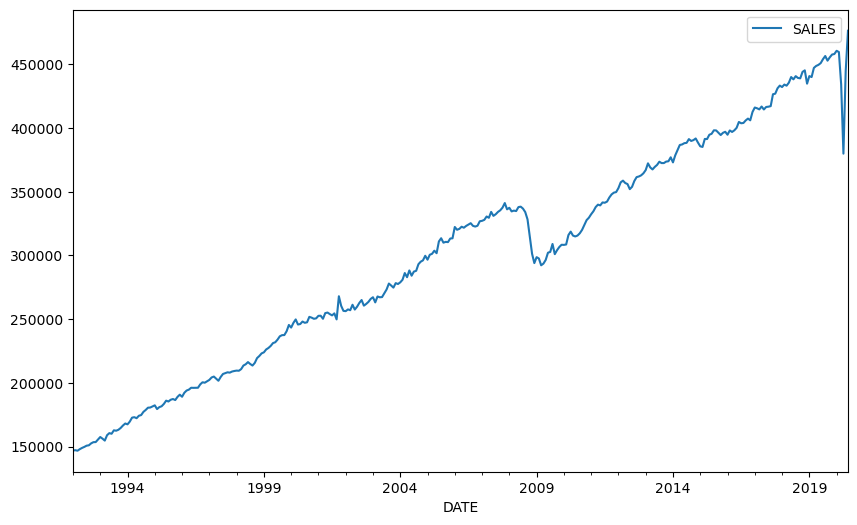

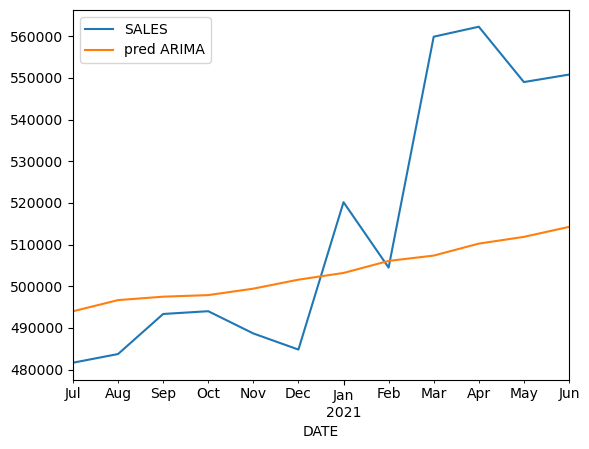

In [24]:
#plotting actual and predicted
df_train.plot(legend = True, label = 'Train', figsize = (10,6))
df_test.plot(legend = True, label = 'Test')
pred.plot(legend = True, label = 'pred ARIMA')